# Difference of Moving Averages

Let's look at how changing the scale of the moving average filter can lead to additional gains

In [28]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib import rc

from skimage.color import rgb2gray
import scipy.signal as signal
from skimage.transform import resize

In [29]:
def imshow_f_dft_pair(z,z_hat,cm='jet'): #helper plotting function
    fig = plt.figure(figsize =(8,4))
    plt.subplot(1, 2, 1)
    plt.imshow(z,cmap='gray', aspect='equal')
    plt.title('z')
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow((np.fft.fftshift(abs(z_hat))),cmap=cm, aspect='equal',origin='lower')  # don't forget to fftshift
    #  For two-dimensional input, swaps first and third quadrants, and second and fourth quadrants.
    plt.xticks(ticks=[0,N/2, N-1], labels=[-N/2,0,N/2]) 
    plt.yticks(ticks=[0,M/2, M-1], labels=[-M/2,0,M/2]) 
    plt.colorbar()
    plt.title('$|\hat{z}|$')
    plt.show()

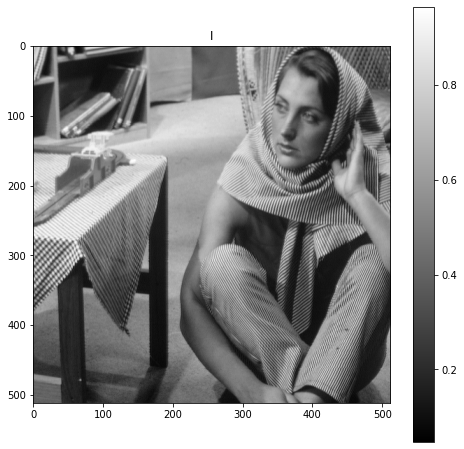

In [30]:
# read an image file
image = plt.imread("barbara.png")

# convert image to grayscale
if np.size(image.shape) > 2:
    image = rgb2gray(image)

# crop image to interger multiple of 8x8
nrows, ncols = image.shape[0], image.shape[1]
if nrows % 8 > 0:
    image = image[0 : 8*int(nrows / 8),:]
if ncols % 8 > 0:
    image = image[:,0 : 8*int(ncols / 8)]
    
# plot image
plt.figure(figsize=(8,8))
plt.imshow(image,cmap='gray')
plt.colorbar()
plt.title('I')
plt.show()


## Here's the largest filter we plan to use, just a moving average filter of size 64

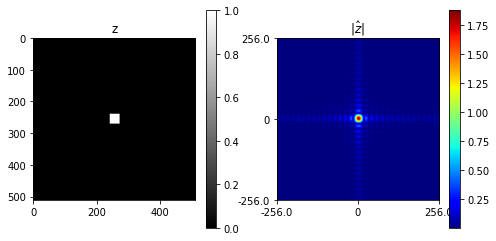

In [33]:
M = nrows # number of rows
N = ncols  # number of columns 

x = np.arange(0,N)  # horizontal grid 
y = np.arange(0,M)  # vertical grid 
xx, yy = np.meshgrid(x, y)

z = np.zeros((M,N))
z[np.logical_and(np.abs(yy-M/2)<16,np.abs(xx-N/2)<16)]=1
z_hat = np.fft.fft2(z, norm='ortho') # calculate the 2D DFT in numpy
imshow_f_dft_pair(z,z_hat)

Let's do this at various scales and look at how much blurr there is at every scale

(1, 1)
(2, 2)
(4, 4)
(8, 8)
(16, 16)
(32, 32)


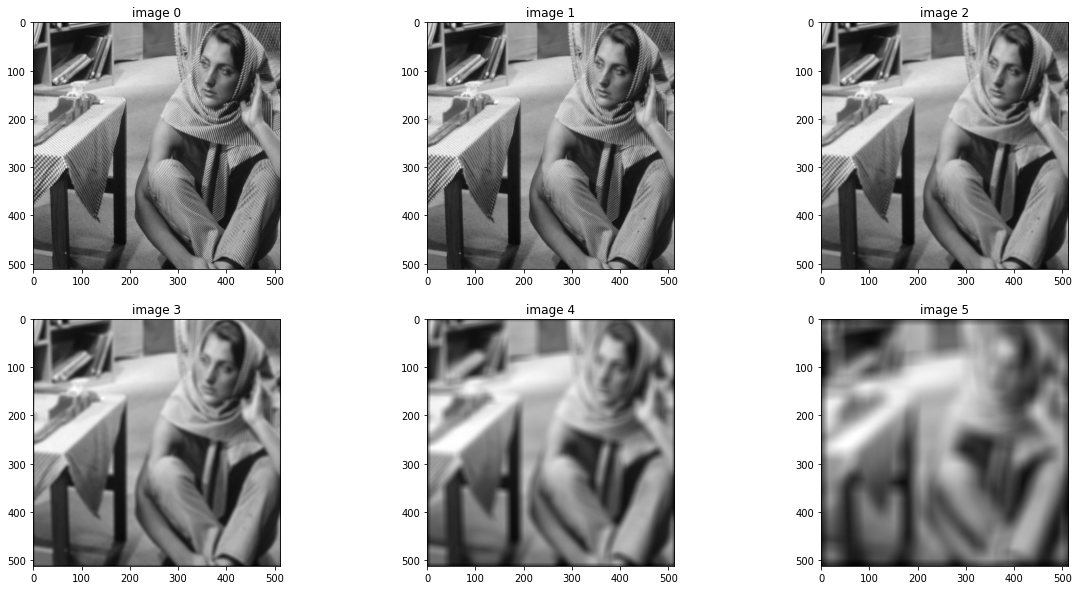

In [36]:
image_MA = []
image_z = []
for i in range(0,6):
    scale = 2**i
    z = 1/(scale**2)*np.ones((scale,scale))
    print(z.shape)

    image_MA_i = signal.convolve2d(image, z, mode='same')
    image_MA.append(image_MA_i)
    
    #print('Done with scale %d' %i)

plt.figure(figsize =(20,10))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(image_MA[i],cmap='gray')
    plt.title('image %d' %i)


## Now let's look at the difference bewteen the original image and each smoothed image

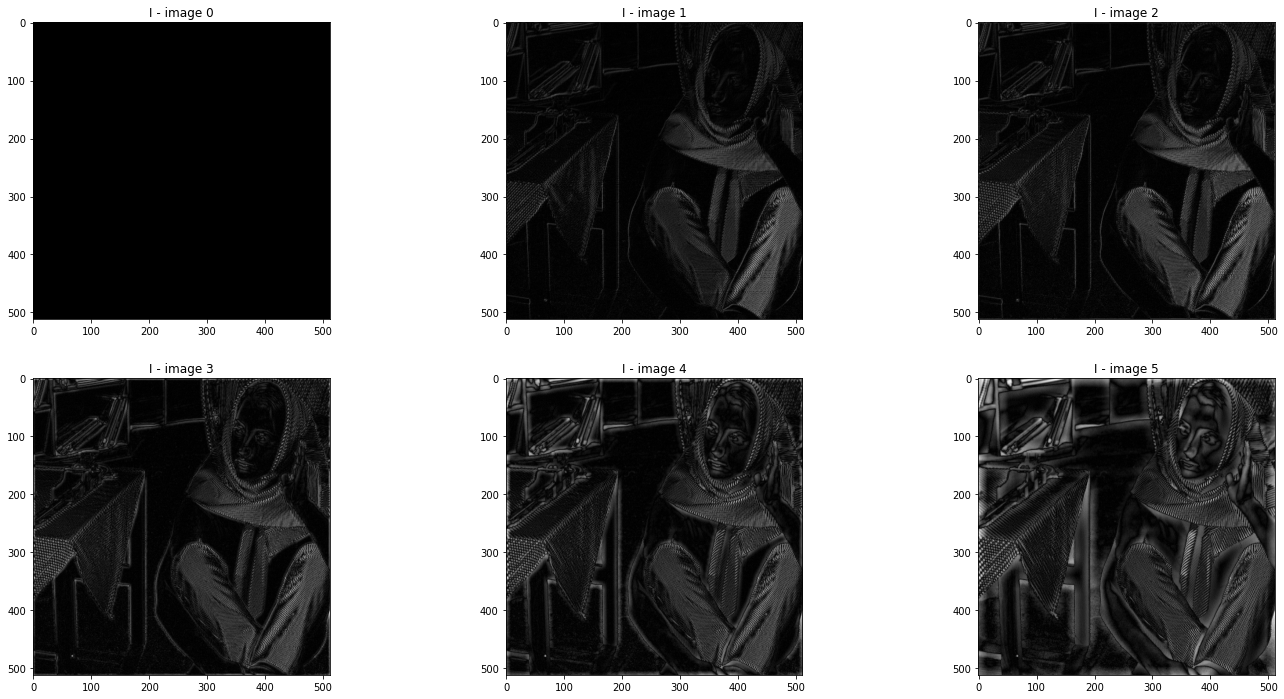

In [37]:
# Difference with original image
plt.figure(figsize =(24,12))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(np.abs(image_MA[0]-image_MA[i]),cmap='gray')
    plt.title('I - image %d' %i)


## This very clearly picks up edges!

The fastest changing edges get picked up with small MA filters, the larger edges get picked up with large MA filters

### Now let's try to look at differences BETWEEN scales

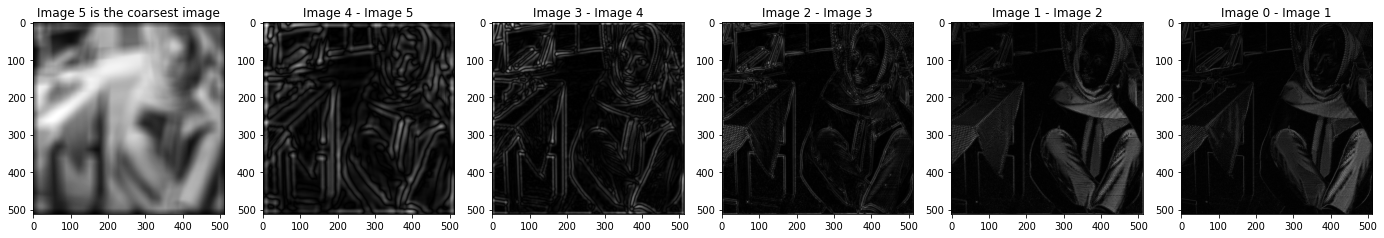

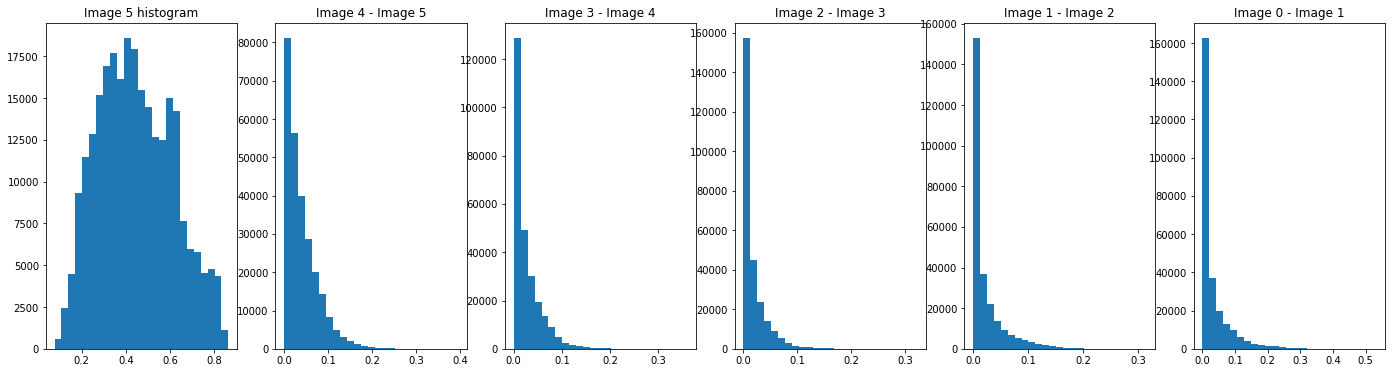

In [38]:
# Difference with previous filter
image_diff = []
plt.figure(figsize =(24,12))
plt.subplot(1,6,1)
image_diff.append(image_MA[5])
plt.imshow(image_diff[0],cmap='gray')
plt.title('Image 5 is the coarsest image')
for i in range(1,6):
    plt.subplot(1,6,i+1)
    image_diff.append(image_MA[5-i] - image_MA[6-i])
    plt.imshow(np.abs(image_diff[i]),cmap='gray')
    plt.title("Image %d" %(5-i) + " - Image %d" %(6-i))


plt.figure(figsize =(24,6))
plt.subplot(1,6,1)
plt.hist(np.abs(image_diff[0].flatten()), bins=25)
plt.title('Image 5 histogram')
for i in range(1,6):
    plt.subplot(1,6,i+1)
    plt.hist(np.abs(image_diff[i].flatten()), bins=25)
    plt.title("Image %d" %(5-i) + " - Image %d" %(6-i))


### Notice that the coarsest scale (MA with size 32x32 square) is really blurred and thus really easy to compress
### Every difference after that is mostly zeros also, so it would be really easy to compress as well

## But what happens if we added these images all together
\begin{align}
I_5 + \sum_{j=0}^4 (I_j - I_{j+1}) &= I_5 + (I_4 - I_5) + (I_3 - I_4) + (I_2 - I_3) + (I_1 - I_2) + (I_0 - I_1)\\
&= I_0 = I
\end{align}

It's a telescoping series, so you'll get back the original image!

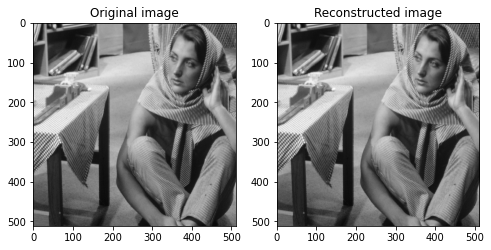

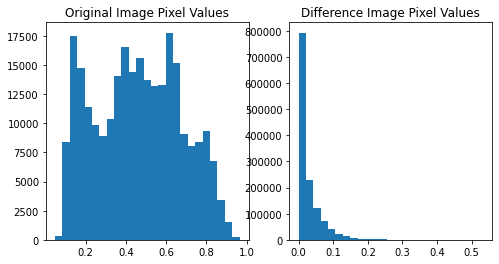

In [39]:
# Add differences back together
total = np.zeros(image.shape)
for i in range(6):
    total = total + image_diff[i]
    
plt.figure(figsize =(8,8))
plt.subplot(1,2,1)
plt.imshow(image,cmap='gray')
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(total,cmap='gray')
plt.title('Reconstructed image')

# Number of large entries in all difference images (ignoring the base image)
plt.figure(figsize =(8,4))
plt.subplot(1,2,1)
x = np.reshape(image,M*N)
plt.hist(np.abs(x), bins=25)
plt.title('Original Image Pixel Values')

plt.subplot(1,2,2)
x = np.zeros(0)
for i in range(1,6):
    tmp = np.reshape(image_diff[i],M*N)
    x = np.concatenate((x,tmp))
#x = x[np.abs(x) > 0.1]

plt.hist(np.abs(x), bins=25)
plt.title('Difference Image Pixel Values')
plt.show()

A version of this replacing the moving average filter with a Gaussian filter is called a Gaussian pyramid, with the difference of filtered images called a Laplacian pyramid. These were proposed for image compression in a foundational paper by Burt and Adelson titled "The Laplacian Pyramid as a Compact Image Code" inn 1983.

